# Lecture 2 - Stat Arb

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Load yfinance data
vanguard_finance_etf = "VFH"
vanguard_consumer_staples_etf = "VDC"
vanguard_consumer_disc_etf = "VCR"
vanguard_industrials_etf = "VIS"
vanguard_IT_etf = "VGT"

df = yf.download(
    tickers=[vanguard_finance_etf, vanguard_consumer_staples_etf, vanguard_consumer_disc_etf, vanguard_IT_etf, vanguard_industrials_etf],
    start="2021-07-03",
    end="2025-01-1",
    progress=False,
    auto_adjust=True
).dropna()['Close']
df = np.log(df).diff().dropna() # Log returns data
df.head()

Ticker,VCR,VDC,VFH,VGT,VIS
Date,,,,,
2021-07-07,-0.001761,0.004949,0.000446,0.003837,0.007273
2021-07-08,-0.003942,-0.002966,-0.019595,-0.009795,-0.013777
2021-07-09,0.011685,0.005650,0.027592,0.009402,0.016409
2021-07-12,0.005388,-0.001095,0.010674,-0.000098,0.001566
2021-07-13,-0.011968,-0.003017,-0.013111,0.002160,-0.010858


### Task 0: Visualize the cumulative sum of the log returns data

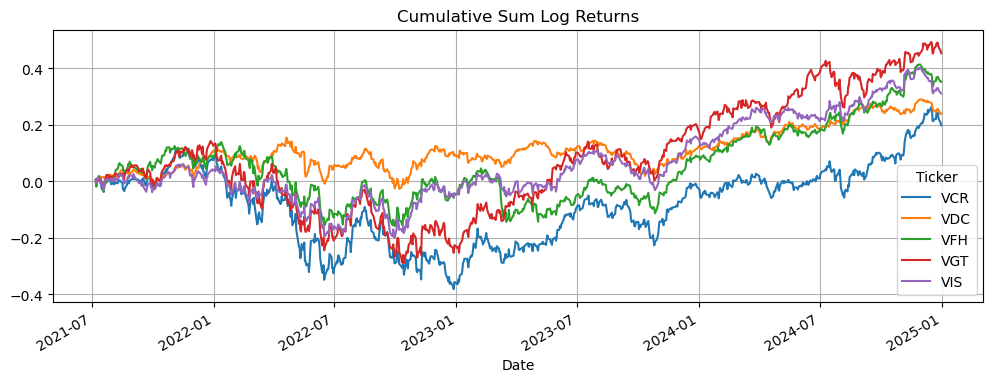

In [3]:
df.cumsum().plot(figsize=(12,4), title="Cumulative Sum Log Returns", grid=True);

### Task 1: Beta and hedging
We assume prices follow:
\begin{equation*}
    r_{VFH} = \sum\beta_{i}r_{i} + \epsilon
\end{equation*}

Note that $\beta_i$ is not necessarily constant over time. In our case, we operate on truncated data so the assumption approximately holds. 

Q: How would using $L_1$ and/or $L_2$ regularization affect $\beta_i$ values (consider accuracy, stability, etc.)? 

**Effect of L₁ vs L₂ Regularization on β Estimates**

| Property | L₂ (Ridge) | L₁ (Lasso) |
|---------|------------|-----------|
| Main effect | Shrinks β magnitudes | Sets some β to zero |
| Stability with correlated assets | High stability | Low stability |
| Hedge exposure | Uses all hedge assets | Sparse hedge assets |
| Variance vs bias tradeoff | Reduces variance, small bias | Higher bias risk |
| Interpretation | Smooth, conservative hedge | Clear factor selection |
| Overfitting control | Strong | Strong but less stable |

**Summary**
- L₂ improves stability and reduces noise in β estimates.
- L₁ performs variable selection and creates simpler hedges.
- Elastic Net can combine both benefits.

#### Task 1.1: Use returns data to calculate rolling beta of VFH against the other assets via linear regression

In [4]:
# Some parameters for reference (DO NOT EDIT)
window_size = 126
assets_to_regress_against = ["VDC","VCR","VIS","VGT"]
rolling_betas = {"VDC":[], "VCR":[], "VIS":[], "VGT":[]} # Dictionary
rolling_dates = []

# Calculate rollings betas
for start in range(len(df) - window_size + 1):

    y_window = df["VFH"].iloc[start : start + window_size]
    x_window = df[["VDC","VCR","VIS","VGT"]].iloc[start : start + window_size]

    model = LinearRegression()
    model.fit(x_window,y_window)

    beta_VDC, beta_VCR, beta_VIS, beta_VGT = model.coef_
    rolling_betas["VDC"].append(beta_VDC)
    rolling_betas["VCR"].append(beta_VCR)
    rolling_betas["VIS"].append(beta_VIS)
    rolling_betas["VGT"].append(beta_VGT)
    rolling_dates.append(df.index[start+window_size-1])
    
# Final dataframe (DO NOT EDIT)
betas = pd.DataFrame(rolling_betas, index=rolling_dates)
betas.columns = ["VDC_beta","VCR_beta","VIS_beta","VGT_beta"]
df = df[df.index >= betas.index[0]]

#### Task 1.2: Plot the cumulative sum of residuals

\begin{equation*}
\epsilon = r_{VFH}-\sum\beta_i r_i
\end{equation*}

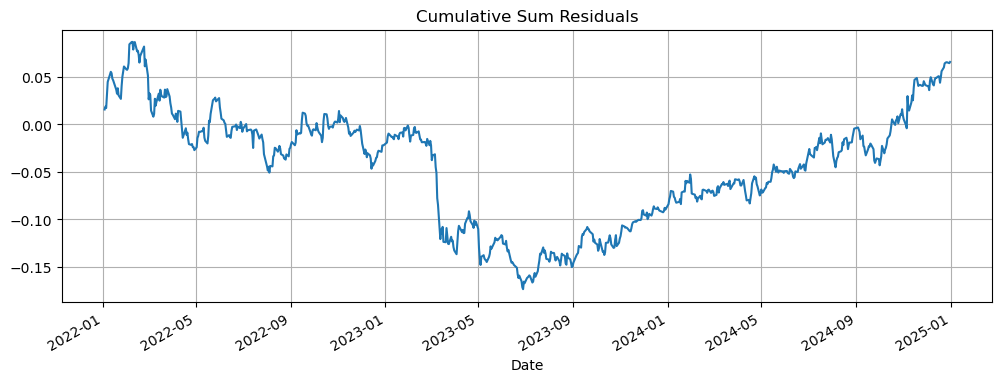

In [5]:
residuals = (df["VFH"] - (betas["VDC_beta"]*df["VDC"] \
                          + betas["VCR_beta"]*df["VCR"] \
                            + betas["VIS_beta"]*df["VIS"] \
                                + betas["VGT_beta"]*df["VGT"])).cumsum()
residuals.plot(figsize=(12,4), title="Cumulative Sum Residuals", grid=True);

#### Task 1.3: Calculate z-score values for your residuals and plot them
Note that here we assume our cumulative sum residuals process follows $d\epsilon = \sigma dB_t$ ,i.e. a random walk.

Q: What if we assume $d\epsilon = \theta(m-\epsilon)dt + \sigma dB_t$ (i.e. an OU process)? How would our standardization formula change?

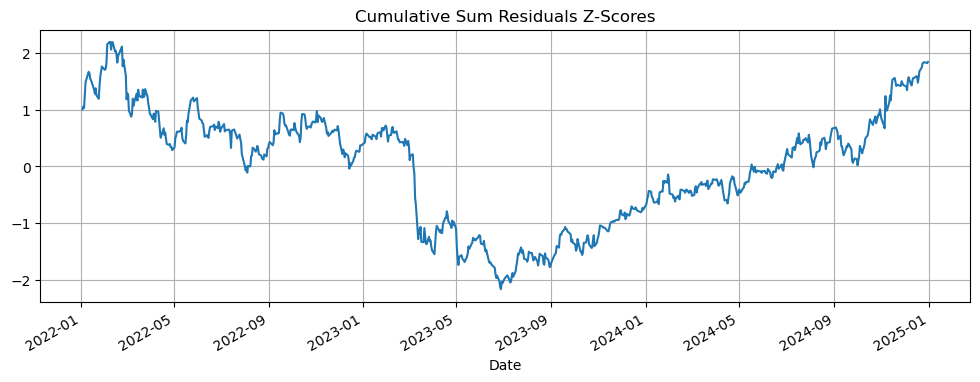

In [6]:
z_scores = (residuals - residuals.mean()) / residuals.std()
z_scores.plot(figsize=(12,4), title="Cumulative Sum Residuals Z-Scores", grid=True);

### Task 2:  Using Z-score values in trading

#### Task 2.1: Choose some entry/exit bounds for going long/short the spread and plot them
Choose values for the following:
- An upper bound $z_1$ where if price crosses from above you short the spread.
- A closing upper bound $z_2$ where if price falls lower to $z_2$ you close your short on the spread.
- A lower bound $z_3$ where if price crosses from below you long the spread.
- A closing lower bound $z_4$ where if the price proceeds to rise to $z_4$ you close your long on the spread. 

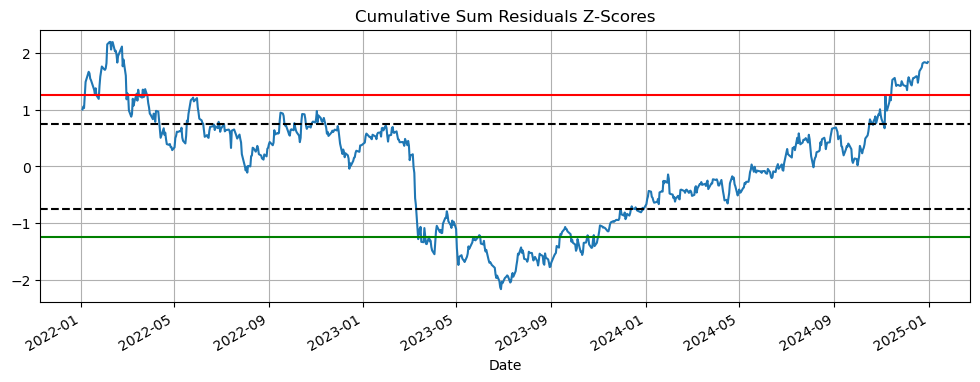

In [7]:
z_upper = 1.25
z_hold_up = 0.75
z_hold_do = -0.75
z_lower = -1.25

z_scores.plot(figsize=(12,4), title="Cumulative Sum Residuals Z-Scores", grid=True)
plt.axhline(z_upper, color="red")
plt.axhline(z_lower, color="green")
plt.axhline(z_hold_up, linestyle='--', color="black")
plt.axhline(z_hold_do, linestyle='--', color="black")
plt.show()

#### Task 2.2: Generate a signals from your z_score strategy

In [ ]:
def get_signals(z_upper, z_lower, z_hold_up, z_hold_do):

    signals = []
    trading_dates = []
    prior_z = None

    for i in range(len(z_scores)):
        z = z_scores.iloc[i]
        date = z_scores.index[i]
        if prior_z == None:
            prior_z = z
            continue
        if prior_z >= z_upper and z_upper >= z and (not signals or signals[-1] != "OPEN SHORT"):
            signals.append("OPEN SHORT")
            trading_dates.append(date)
        elif prior_z >= z_hold_up and z_hold_up >= z and signals and signals[-1] == "OPEN SHORT":
            signals.append("CLOSE SHORT")
            trading_dates.append(date)
        elif prior_z <= z_lower and z_lower <= z and (not signals or signals[-1] != "OPEN LONG"):
            signals.append("OPEN LONG")
            trading_dates.append(date)
        elif prior_z <= z_hold_do and z_hold_do <= z and signals and signals[-1] == "OPEN LONG":
            signals.append("CLOSE LONG")
            trading_dates.append(date)
        prior_z = z

    trading_signals = pd.Series(signals, index=trading_dates)

    return trading_signals

In [9]:
trading_signals = get_signals(z_upper, z_lower, z_hold_up, z_hold_do)

#### Task 2.3: Generate the backtest results of your current strategy, using beta values from earlier assuming you adjust your beta hedge at every time step with newly calculated beta.
Q: If you consider transaction costs, how would you optimally update beta?

In [20]:
def get_wealth(trading_signals):

    wealth = [1]
    positions = {"VFH":0,"VDC":0,"VCR":0,"VIS":0,"VGT":0}

    for i in range(1,len(df)):

        date = df.index[i]
        change = sum([df[key].iloc[i]*val for key,val in positions.items()])
        wealth.append(wealth[-1] + change)

        if date in trading_signals.index:

            signal = trading_signals[date]
            #print(trading_signals[date])

            if signal == "OPEN SHORT":
                positions["VFH"] = -1
                positions["VDC"] = betas["VDC_beta"].iloc[i]
                positions["VCR"] = betas["VCR_beta"].iloc[i]
                positions["VIS"] = betas["VIS_beta"].iloc[i]
                positions["VGT"] = betas["VGT_beta"].iloc[i]

            elif signal == "OPEN LONG":
                positions["VFH"] = 1
                positions["VDC"] = -betas["VDC_beta"].iloc[i]
                positions["VCR"] = -betas["VCR_beta"].iloc[i]
                positions["VIS"] = -betas["VIS_beta"].iloc[i]
                positions["VGT"] = -betas["VGT_beta"].iloc[i]

            else:
                positions = {"VFH":0,"VDC":0,"VCR":0,"VIS":0,"VGT":0}

        if positions["VFH"] != 0:
            if positions["VFH"] == -1:
                positions["VDC"] = betas["VDC_beta"].iloc[i]
                positions["VCR"] = betas["VCR_beta"].iloc[i]
                positions["VIS"] = betas["VIS_beta"].iloc[i]
                positions["VGT"] = betas["VGT_beta"].iloc[i]
            else:
                positions["VDC"] = -betas["VDC_beta"].iloc[i]
                positions["VCR"] = -betas["VCR_beta"].iloc[i]
                positions["VIS"] = -betas["VIS_beta"].iloc[i]
                positions["VGT"] = -betas["VGT_beta"].iloc[i]
        
    wealth_df = pd.Series(wealth, index=df.index)

    return wealth_df

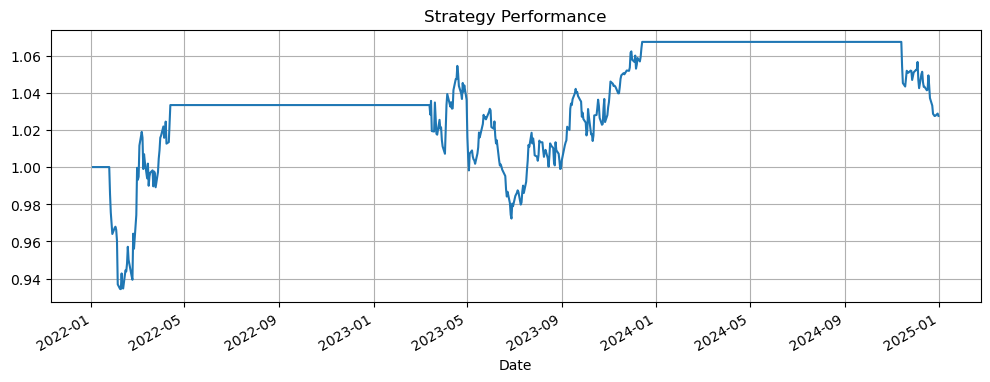

In [22]:
wealth_df = get_wealth(trading_signals)
wealth_df.plot(figsize=(12,4), title="Strategy Performance", grid=True);

#### Bonus: Optimize the bound values
You can brute force optimization using for loops. Once you do this try using the library ```optuna``` for faster optimization.

In [40]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):

    z_upper = trial.suggest_float("z_upper", 1.5, 3.0)
    z_lower = trial.suggest_float("z_lower", -3.0, -1.5)
    z_hold_up = trial.suggest_float("z_hold_up", 0.5, z_upper)
    z_hold_do = trial.suggest_float("z_hold_do", z_lower, -0.5)

    trading_signals = get_signals(z_upper, z_lower, z_hold_up, z_hold_do)
    wealth_df = get_wealth(trading_signals)
    
    return wealth_df.iloc[-1]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)
study.best_params

Best trial: 82. Best value: 1.19008: 100%|██████████| 100/100 [00:01<00:00, 56.57it/s]


{'z_upper': 2.127282693415391,
 'z_lower': -1.9813513290164877,
 'z_hold_up': 0.7679192190979119,
 'z_hold_do': -0.5177217848952119}

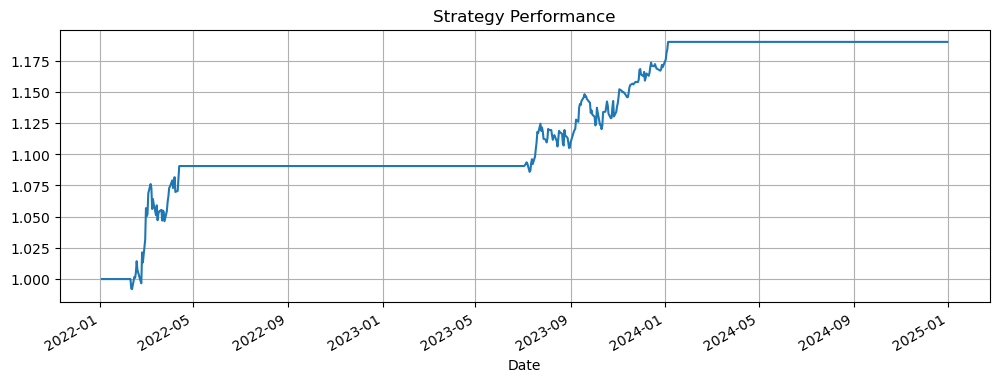

In [41]:
trading_signals = get_signals(**study.best_params)
wealth_df = get_wealth(trading_signals)
wealth_df.plot(figsize=(12,4), title="Strategy Performance", grid=True);

#### Extension:
- Try splitting the dataset into train and test to see if bounds fitted for train work on trading the test set, and if so for how long.
- Experiment with delta hedging on options data using options ladders from yahoo finance.
- Formulate your own linear factor models with factors outside of returns data.
- Explor nonlinear factor models and how positions sizing for hedging works in a nonlinear context.